# Image inpainting

Example of image inpainting using NIHT


In [1]:
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import cv2

import pylops

from nopt.transforms import *
from nopt.constraints import *
from nopt.problems import *
from nopt.solvers import *

In [2]:
# Load image
img = cv2.imread('../data/cameraman.jpg', 0) 

delta = 0.5
rho = 0.1
p = round(delta * 512**2) # number of samples
s = round(p * rho) # sparsity

mask = np.random.choice(512**2,p,replace = False)
P_omega = EntryWise(mask, 512**2)
Wave2d = pylops.signalprocessing.DWT2D(img.shape, level=2, wavelet = 'db4')

img_coeff = Wave2d.matvec(img.flatten())

The model is
$$ \min_c \| P_\Omega( \Psi^*(c) )) - b \|_2 \qquad \mathrm{s.t.}\qquad \|c\|_0 \leq s$$
where $P_\Omega$ is an entrywise subsampling and $\Psi$ is an 2D Wavelet transform.

In [3]:
A = CompositeTransform([Wave2d.adjoint(), P_omega])
HTs = Sparsity(s)
b = P_omega.matvec(img.flatten())

sub, x_true = HTs.project(img_coeff)
problem = LinearProblem(A, b, HTs, x_true = x_true)
solver = NIHT(logverbosity = 2, maxiter = 100, verbosity = 2, minreldecrease = 1-1e-3)

In [4]:
x, opt_log = solver.solve(problem)

 iter		   obj. value	    grad. norm	     xdist
    1	+4.8505339326423816e+07	2.41858666e+04
    2	+2.2424988597533945e+07	9.84939991e+03
    3	+1.5335120492017245e+07	6.69701256e+03
    4	+1.2049361174043991e+07	5.53807196e+03
    5	+1.1276851642067933e+07	4.90904495e+03
    6	+1.0036220729188804e+07	4.74907394e+03
    7	+9.9814125880105942e+06	4.48022784e+03
    8	+9.4732087313024122e+06	4.46797775e+03
    9	+9.7850076024334189e+06	4.35274827e+03
   10	+9.1331109165256787e+06	4.42380099e+03
   11	+9.3059910766279176e+06	4.27390007e+03
   12	+8.9596177744069789e+06	4.31416065e+03
   13	+9.0630320330142751e+06	4.23311180e+03
   14	+8.9130832344872430e+06	4.25747156e+03
   15	+9.0046725205146931e+06	4.22210451e+03
   16	+8.8876089762980118e+06	4.24374187e+03
   17	+8.9322928034722675e+06	4.21606664e+03
   18	+8.8547379148881305e+06	4.22665182e+03
   19	+8.9249307895295992e+06	4.20826280e+03
   20	+8.8507313405183125e+06	4.22490965e+03
   21	+8.8859891929002553e+06	4.20731062e+03
   22	+8

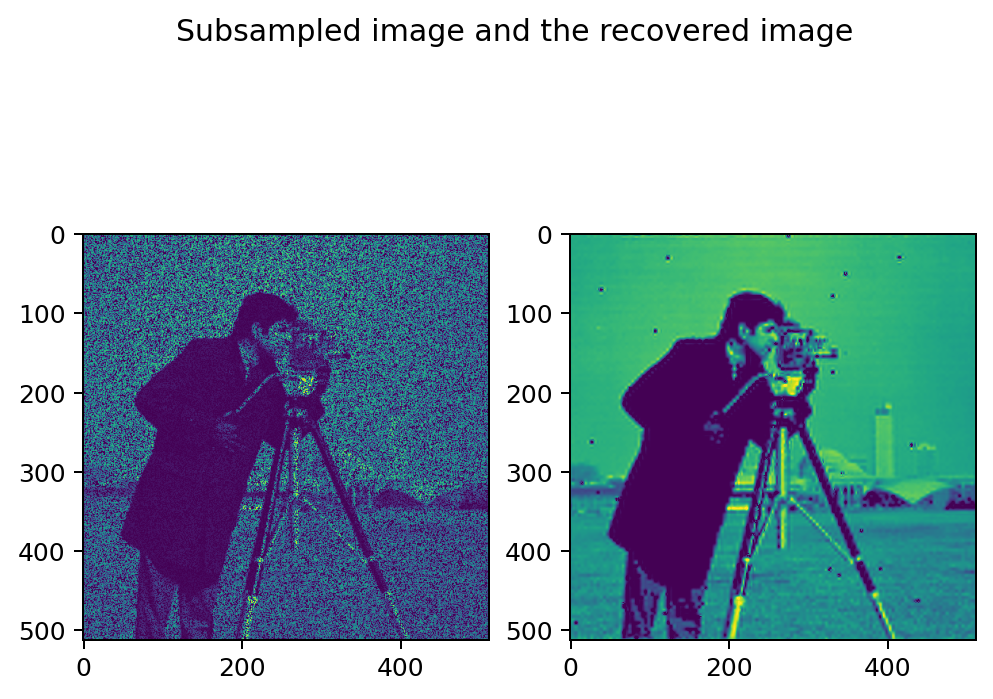

In [8]:
fig, axs = plt.subplots(1,2, dpi=180)
fig.suptitle('Subsampled image and the recovered image')
plt1 = axs[0].imshow(P_omega.rmatvec(b).reshape(512,512), vmin = 0, vmax=256)
plt2 = axs[1].imshow(Wave2d.rmatvec(x).reshape(512,512), vmin = 0, vmax=256)
plt.show()

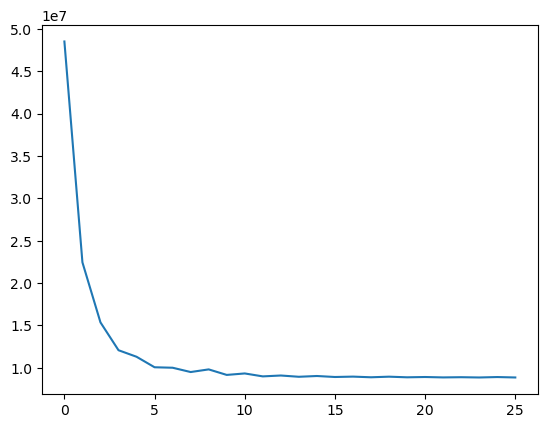

In [6]:
plt.plot(opt_log['iterations']['fx'])